In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import interact
from keino import Params, k_path, pprint, add_colourbar, vectorize_parallel, colours, build_axes_grid
from ristikko import System, Space, models, Symbol, Site
import joblib

mem = joblib.Memory("cache")

# Square lattice

## No sublattice

First we look at some simple cases where there is no sublattice (i.e., a unit cell with a single site).

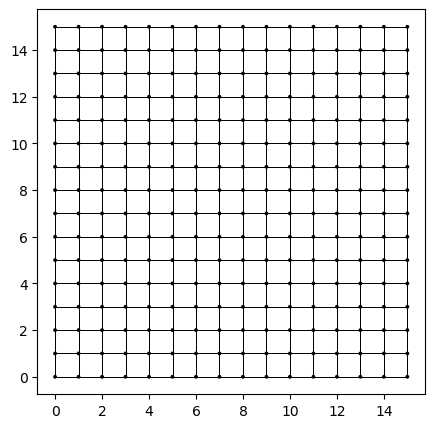

In [2]:
# Parameters for the system
params = Params(dict(
    N1 = 16,        # number of sites in the a1 direction
    N2 = 16,        # number of sites in the a2 direction
    mu = 0,         # chemical potential
    t = 1,          # hopping energy
    pbc = False,    # open boundary conditions
))

# Create a realspace system, on a square lattice
# The second argument could also be a lattice object
# if you want more control, e.g.
# lattice = models.Square()
realspace = System(Space.RealSpace, "square", params)

# Plot the system
# The system must be in real space to plot
realspace.plot()

### Sanity check - test that the spectra matches the analytic expression

In [3]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 4)
params = dict(
        mu = rands[0],
        Jz = rands[1],
        t = 1,
        alpha = rands[2],
        Delta = rands[3],
)
params = Params(params)

# Create a path along high symmetry points in momentum space
points = np.array([
    [0, 0],
    [0.5, 0],
    [0.5, 0.5],
    [0, 0.5],
    [0, 0]
]) * 2 * np.pi
Ks = np.array(k_path(101, points))

# Analytic spectra
ek = 2 * params.t * (np.cos(Ks[:, 0]) + np.cos(Ks[:, 1])) - params.mu
ak = 2 * params.alpha * (np.sin(Ks[:, 0]) + np.sin(Ks[:, 1]))
ref = np.array([
        np.sqrt(params.Jz**2 + params.Delta**2 + ek**2 + ak**2 + 2 * np.sqrt(params.Jz**2 * (params.Delta**2 + ek**2) + ek**2 * ak**2)),
        np.sqrt(params.Jz**2 + params.Delta**2 + ek**2 + ak**2 - 2 * np.sqrt(params.Jz**2 * (params.Delta**2 + ek**2) + ek**2 * ak**2)),
        -np.sqrt(params.Jz**2 + params.Delta**2 + ek**2 + ak**2 + 2 * np.sqrt(params.Jz**2 * (params.Delta**2 + ek**2) + ek**2 * ak**2)),
        -np.sqrt(params.Jz**2 + params.Delta**2 + ek**2 + ak**2 - 2 * np.sqrt(params.Jz**2 * (params.Delta**2 + ek**2) + ek**2 * ak**2)),
])

kspace = System(Space.KSpace, "square", params)
Ek = kspace.diagonalise(k=Ks, cache=False)

# Compare the spectra
ref = np.sort(ref.flatten())
Ek_flat = np.sort(Ek.flatten())
test = abs(ref - Ek_flat).max()

assert test < 1e-13

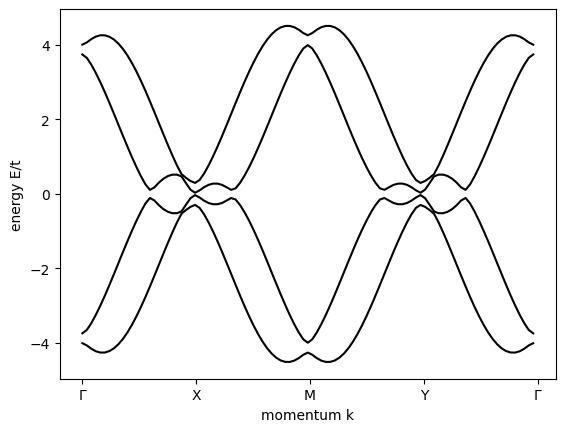

In [4]:
fig, axis = plt.subplots()
axis.plot(Ek, color="black")
axis.set_xlabel("momentum k")
axis.set_ylabel("energy E/t")

ticks = np.linspace(0, 101, 5)
labels = [r"$\Gamma$", "X", "M", "Y", r"$\Gamma$"]
axis.set_xticks(ticks, labels)

### Sanity check - test that the momentum-space spectra matches real space

In [5]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 6)
params = dict(
        N1 = 16,
        N2 = 16,
        mu = rands[0],
        Jx = rands[1],
        Jy = rands[2],
        Jz = rands[3],
        t = 1,
        alpha = rands[4],
        Delta = rands[5],
        pbc = True,
)
params = Params(params)

# Create a real space system
realspace = System(Space.RealSpace, "square", params)

# Compare to momentum space
# Under the bonnet this creates an equivalent system in momentum space,
# discretises the Brillouin zone appropriately,
# and compares the eigenenergies
assert realspace == Space.KSpace

### Sanity check - test that the momentum-space spectra matches a ribbon

In [6]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 6)

params_ribbon = dict(
        N1 = 6,              # use 6 discretisation points in momentum space
        N2 = 5,
        L = 5,
        mu = rands[0],
        Jx = rands[1],
        Jy = rands[2],
        Jz = rands[3],
        t = 1,
        alpha = rands[4],
        Delta = rands[5],
        pbc = True,
        direction = "a1",    # Fourier-transform along the a1 direction
)
params_ribbon = Params(params_ribbon)
params_kspace = dict(
        N1 = 6,
        N2 = 5,
        mu = rands[0],
        Jx = rands[1],
        Jy = rands[2],
        Jz = rands[3],
        t = 1,
        alpha = rands[4],
        Delta = rands[5],
)
params_kspace = Params(params_kspace)

syst = System(Space.Ribbon, "square", params_ribbon)
kspace = System(Space.KSpace, "square", params_kspace)

assert syst == kspace

### Ribbon band structure

In [7]:
params = Params(dict(
    L = 11,
    mu = 0,
    t = 1,
    direction = "a2",    # Fourier transform along the a2 direction
    pbc = False,
))

# Create system
syst = System(Space.Ribbon, "square", params)

# Discretise momenta
nk = 101
Ks = np.linspace(-np.pi, np.pi, nk)
Ek = np.array(syst.diagonalise(k=Ks, dense=True, cache=False))

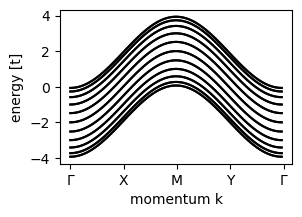

In [8]:
fig, axis = plt.subplots(figsize=(3, 2))
axis.plot(Ek/params.t, color="black")
axis.set_xlabel("momentum k")
axis.set_ylabel("energy [t]")
ticks = np.linspace(0, nk, 5)
labels = [r"$\Gamma$", "X", "M", "Y", r"$\Gamma$"]
axis.set_xticks(ticks, labels)
plt.show()

### Density of states and local density of states

In [9]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 6)
params = dict(
        N1 = 16,
        N2 = 16,
        mu = rands[0],
        Jx = rands[1],
        Jy = rands[2],
        Jz = rands[3],
        t = 1,
        alpha = rands[4],
        Delta = rands[5],
        pbc = True,
)
params = Params(params)

# Create a real space system
realspace = System(Space.RealSpace, "square", params)

# Calculate the LDOS
omega = np.linspace(-0.1, 0.1, 1001)
ldos = realspace.calc_ldos(omega)   # returns shape particle/hole, N1, N2, N1_sub, N2_sub, n_orbitals, len(omega)

Text(0, 0.5, 'DOS [a.u]')

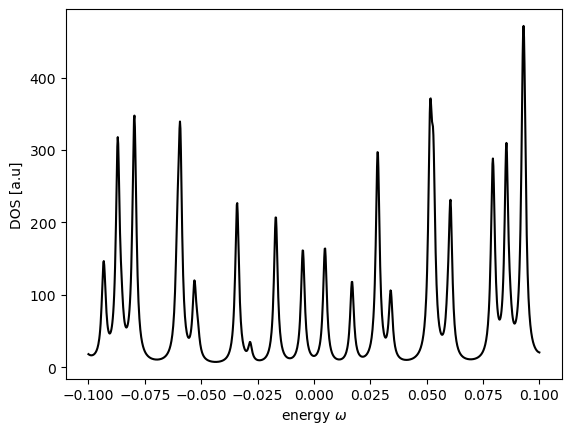

In [10]:
dos = ldos[0].sum(axis=(0, 1, 2, 3, 4))

fig, axis = plt.subplots()

axis.plot(omega, dos, color="black")
axis.set_xlabel(r"energy $\omega$")
axis.set_ylabel("DOS [a.u]")

In [11]:
import scipy.interpolate as interpolate

@interact(idx=(0, len(omega)-1))
def play(idx=0):
    _ldos = ldos[0, :, :, 0, 0, :, idx].sum(axis=-1)

    y = np.arange(params.N1)
    x = np.arange(params.N2)
    interp = interpolate.RegularGridInterpolator((x, y), _ldos, bounds_error=False, fill_value=None)
    
    Y = np.linspace(0, params.N1, 400)
    X = np.linspace(0, params.N2, 400)
    X, Y = np.meshgrid(X, Y)
    ldos_interp = interp((X, Y))
    
    fig, axis = plt.subplots(figsize=(5, 5))
    im = axis.contourf(ldos_interp)

    add_colourbar(fig, axis, im)

    axis.set_xlabel("x")
    axis.set_ylabel("y")
    axis.set_xticks([])
    axis.set_yticks([])

interactive(children=(IntSlider(value=0, description='idx', max=1000), Output()), _dom_classes=('widget-intera…

### Shiba chain

#### Band structure

In [12]:
params = dict(
    t = 1,
    mu = 2,
    Jz = 2,
    alpha = 0.5,
    Delta = 1,
    direction = "a1",
)
params = Params(params)

# Create a path along high symmetry points in momentum space
points = np.array([
    [0, 0],
    [1, 0],
]) * 2 * np.pi
Ks = np.array(k_path(101, points))

kspace = System(Space.KSpace, "square", params)
Ek = kspace.diagonalise(k=Ks, cache=False)

print(Ek[:, 2].min())

0.44948974278317805


Text(0, 0.5, 'energy E/t')

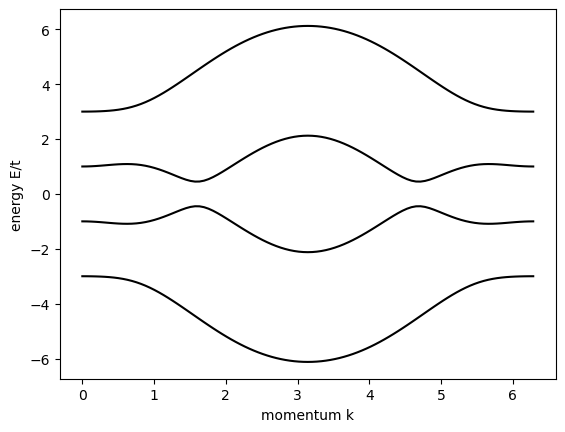

In [13]:
fig, axis = plt.subplots()
axis.plot(Ks[:, 0], Ek, color="black")
axis.set_xlabel("momentum k")
axis.set_ylabel("energy E/t")

#### Ribbon spectra

In [14]:
params = Params(dict(
    L = 61,
    t = 1,
    mu = 2,
    Jz = 2,
    alpha = 0.5,
    Delta = 1,
    direction = "a1",
    pbc = True,
))

pbc = System(Space.Ribbon, "square", params)
params.pbc = False
obc = System(Space.Ribbon, "square", params)

nk = 101
Ks = np.linspace(-np.pi, np.pi, nk)
E_pbc = np.array(pbc.diagonalise(k=Ks, dense=True, cache=False))
E_obc = np.array(obc.diagonalise(k=Ks, dense=True, cache=False))

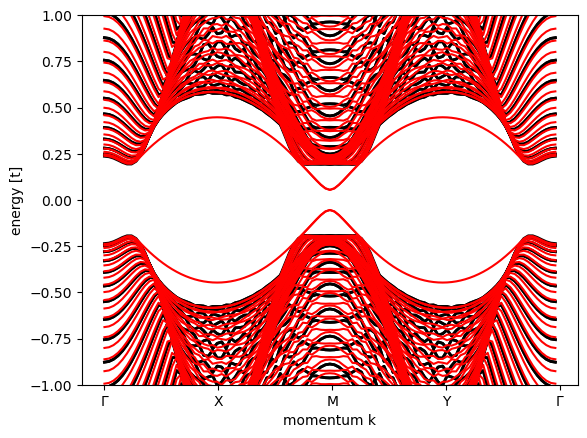

In [15]:
fig, axis = plt.subplots()
axis.plot(E_pbc, color="black", lw=2)
axis.plot(E_obc, color="red")
axis.set_xlabel("momentum k")
axis.set_ylabel("energy [t]")
ticks = np.linspace(0, nk, 5)
labels = [r"$\Gamma$", "X", "M", "Y", r"$\Gamma$"]
axis.set_xticks(ticks, labels)
axis.set_ylim(-1, 1)
plt.show()

#### Topology

In [16]:
@vectorize_parallel
def calc(mu, J):
    params = dict(
            t = 1,
            mu = mu.tolist(),
            Jz = J.tolist(),
            alpha = 0.5,
            Delta = 1,
            direction = "a2",
    )
    params = Params(params)
    
    sys = System(Space.KSpace, "square", params) 
    M = sys.calc_majorana()
    return M

In [67]:
Mus = np.linspace(-4, 4, 301)
Js = np.linspace(-4, 4, 303)

M = calc(Mus[None, :], Js[:, None], mem=mem, progress=True, refresh_cache=True)

  0%|          | 0/91203 [00:00<?, ?it/s]

(<matplotlib.colorbar.Colorbar at 0x7f35432bc050>, <Axes: >)

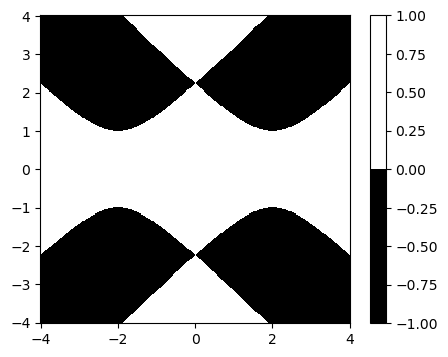

In [68]:
fig, axis = plt.subplots(figsize=(4, 4))
cmap = colours.BlackWhite()
im = axis.pcolormesh(Mus, Js, M, cmap=cmap)
add_colourbar(fig, axis, im)

#### Realspace

In [17]:
params = dict(
    N1 = 16,
    N2 = 1,
    t = 1,
    mu = 2,
    Jz = 2,
    alpha = 0.5,
    Delta = 1,
    pbc = False,
)
params = Params(params)

realspace = System(Space.RealSpace, "square", params)


omega = np.linspace(-1.5, 1.5, 1001)
ldos = realspace.calc_ldos(omega, delta=1e-2)   # returns shape particle/hole, N1, N2, N1_sub, N2_sub, n_orbitals, len(omega)

Text(0, 0.5, 'DOS [a.u]')

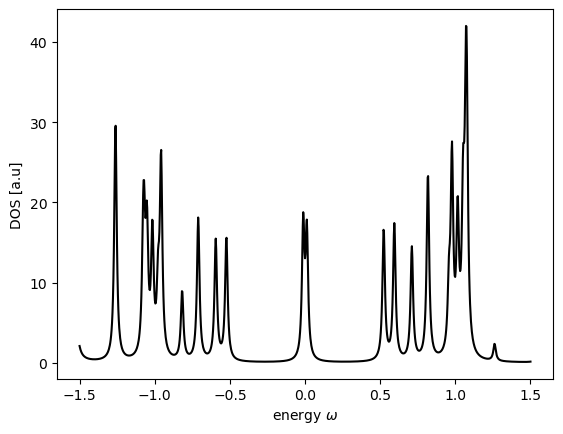

In [18]:
dos = ldos[0].sum(axis=(0, 1, 2, 3, 4))

fig, axis = plt.subplots()

axis.plot(omega, dos, color="black")
axis.set_xlabel(r"energy $\omega$")
axis.set_ylabel("DOS [a.u]")

In [93]:
import scipy.interpolate as interpolate

@interact(idx=(0, len(omega)-1))
def play(idx=len(omega)//2):
    _ldos = ldos[0, :, :, 0, 0, :, idx].sum(axis=-1)

    fig, axis = plt.subplots(figsize=(5, 5))
    axis.plot(_ldos, ".-", color="black")

    axis.set_xlabel("x")
    axis.set_ylabel("y")

interactive(children=(IntSlider(value=500, description='idx', max=1000), Output()), _dom_classes=('widget-inte…

#### Compare gaps

In [19]:
@vectorize_parallel
def calc_kspace(mu, J):
    params = dict(
            t = 1,
            mu = mu.tolist(),
            Jz = J.tolist(),
            alpha = 0.5,
            Delta = 1,
            direction = "a2",
    )
    params = Params(params)
    
    sys = System(Space.KSpace, "square", params) 
    return sys.calc_gap(Ks=Ks)

@vectorize_parallel
def calc_realspace(mu, J):
    params = dict(
        N1 = 16,
        N2 = 1,
        t = 1,
        mu = mu.tolist(),
        Jz = J.tolist(),
        alpha = 0.5,
        Delta = 1,
        pbc = False,
    )
    params = Params(params)
    
    realspace = System(Space.RealSpace, "square", params)
    E = realspace.diagonalise()
    return E[11]

In [43]:
Mus = np.linspace(-4, 4, 31)
Js = np.linspace(-4, 4, 33)
Ks = np.linspace(0, 2*np.pi, 101)

gaps_kspace = calc_kspace(Mus[None, :], Js[:, None], progress=True)
gaps_realspace = calc_realspace(Mus[None, :], Js[:, None], progress=True)

  0%|          | 0/1023 [00:00<?, ?it/s]

  0%|          | 0/1023 [00:00<?, ?it/s]

Text(0, 0.5, 'exchange strength $J/t$')

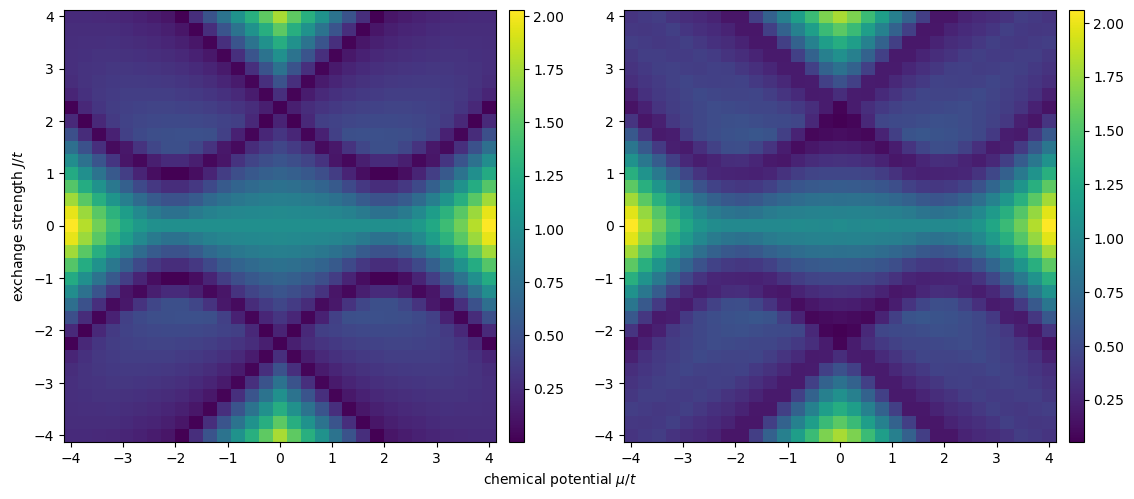

Exception ignored in: <function ResourceTracker.__del__ at 0x7f12df990180>
Traceback (most recent call last):
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f95b5898180>
Traceback (most recent call last):
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py",

In [50]:
fig = plt.figure()
axes = build_axes_grid(fig, 2, 1, aspect=1, xspace=0.2)

im = axes[0].pcolormesh(Mus, Js, gaps_kspace)
add_colourbar(fig, axes[0], im, xscale=0.035, xoff=0.02)
im = axes[1].pcolormesh(Mus, Js, gaps_realspace)
add_colourbar(fig, axes[1], im, xscale=0.035, xoff=0.02)

axes[0].set_xlabel(r"chemical potential $\mu/t$", x=1.15)
axes[0].set_ylabel("exchange strength $J/t$")

### Shiba island

#### Band structure

In [20]:
params = dict(
    t = 1,
    mu = 2,
    Jz = 2,
    alpha = 0.5,
    Delta = 1,
)
params = Params(params)

# Create a path along high symmetry points in momentum space
nk = 101
points = np.array([
    [0, 0],
    [0.5, 0],
    [0.5, 0.5],
    [0, 0.5],
    [0, 0],
]) * 2 * np.pi
Ks = np.array(k_path(nk, points))

kspace = System(Space.KSpace, "square", params)
Ek = kspace.diagonalise(k=Ks, cache=False)

print(Ek[:, 2].min())

0.1940886173701083


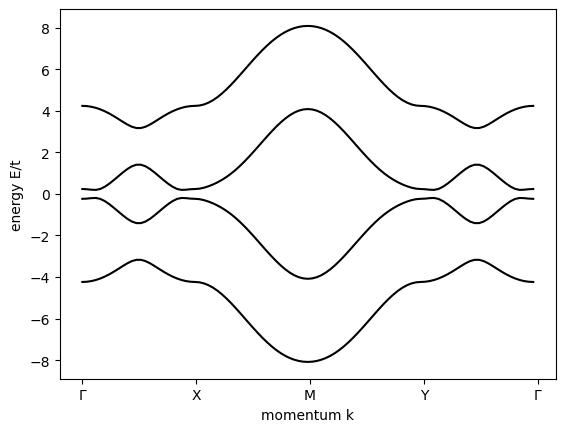

In [113]:
fig, axis = plt.subplots()
axis.plot(Ek, color="black")
axis.set_xlabel("momentum k")
axis.set_ylabel("energy E/t")

ticks = np.linspace(0, nk, 5)
labels = [r"$\Gamma$", "X", "M", "Y", r"$\Gamma$"]
axis.set_xticks(ticks, labels)

#### Ribbon spectra

In [21]:
params = Params(dict(
    L = 61,
    t = 1,
    mu = 2,
    Jz = 2,
    alpha = 0.5,
    Delta = 1,
    pbc = True,
))

pbc = System(Space.Ribbon, "square", params)
params.pbc = False
obc = System(Space.Ribbon, "square", params)

nk = 101
Ks = np.linspace(-np.pi, np.pi, nk)
E_pbc = np.array(pbc.diagonalise(k=Ks, dense=True, cache=False))
E_obc = np.array(obc.diagonalise(k=Ks, dense=True, cache=False))

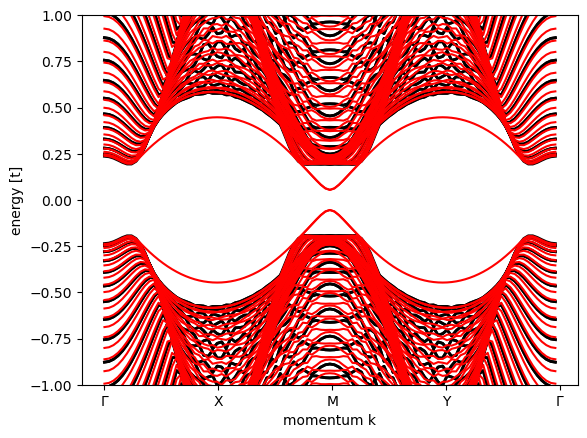

In [115]:
fig, axis = plt.subplots()
axis.plot(E_pbc, color="black", lw=2)
axis.plot(E_obc, color="red")
axis.set_xlabel("momentum k")
axis.set_ylabel("energy [t]")
ticks = np.linspace(0, nk, 5)
labels = [r"$\Gamma$", "X", "M", "Y", r"$\Gamma$"]
axis.set_xticks(ticks, labels)
axis.set_ylim(-1, 1)
plt.show()

#### Topology

In [22]:
@vectorize_parallel
def calc(mu, J):
    params = dict(
            t = 1,
            mu = mu.tolist(),
            Jz = J.tolist(),
            alpha = 0.5,
            Delta = 1,
    )
    params = Params(params)
    
    sys = System(Space.KSpace, "square", params) 
    C = sys.calc_chern(cache=False)
    return C

In [19]:
Mus = np.linspace(-4, 4, 31)
Js = np.linspace(-4, 4, 33)
C = calc(Mus[None, :], Js[:, None], progress=True)
idx = Mus.size // 2 + 1
C[idx] = 0

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2602/1665674438.py:13: SyntaxWarning: invalid escape sequence '\m'
  axis.set_xlabel(f"chemical potential $\mu/t$")


Text(0, 0.5, 'exchange energy $J/t$')

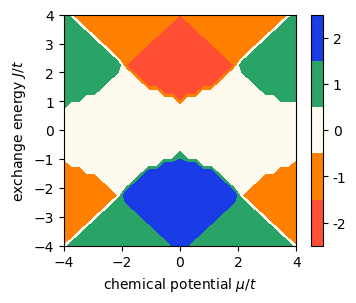

In [42]:
from matplotlib.colors import LinearSegmentedColormap

fig, axis  = plt.subplots(figsize=(3, 3))

cmap = [colours.default["red"], colours.default["orange"], colours.default["white"], colours.default["green"], colours.default["blue"]]
cmap = LinearSegmentedColormap.from_list("spectral", colours.RGB(cmap), 5)

levels = [-3, -2, -1, 0, 1, 2]
im = axis.contourf(Mus, Js, C, levels, cmap=cmap)
cbar, cax = add_colourbar(fig, axis, im)
cax.set_yticks([-2.5, -1.5, -0.5, 0.5, 1.5], [-2, -1, 0, 1, 2])

axis.set_xlabel(f"chemical potential $\mu/t$")
axis.set_ylabel("exchange energy $J/t$")

## With sublattice

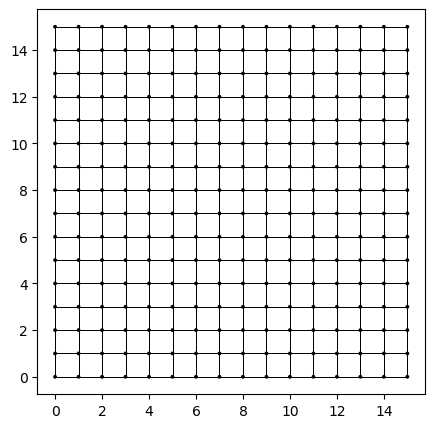

In [3]:
# Generate some parameters

params = dict(
    N1 = 8,
    N2 = 8,
    t = 1,
    pbc = False,
)
params = Params(params)

# Create a system with 8x8 points on the superlattice, and 2x2 sites in the sublattice
four_site = models.Square(N1=2, N2=2)
lattice = models.Square()
lattice.add_sublattice(four_site)
sys = System(Space.RealSpace, lattice, params)

sys.plot()

### Sanity check - test that a system with a sublattice matches an equivalent system with no sublattice

In [46]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 6)

params = dict(
    N1 = 8,
    N2 = 8,
    mu = rands[0],
    Jx = rands[1],
    Jy = rands[2],
    Jz = rands[3],
    t = 1,
    alpha = rands[4],
    Delta = rands[5],
    pbc = True,
)
params = Params(params)

# Create a system with 8x8 points on the superlattice, and 2x2 sites in the sublattice
four_site = models.Square(N1=2, N2=2)
lattice = models.Square()
lattice.add_sublattice(four_site)
left = System(Space.KSpace, lattice, params)

# Create an equivalent system with 16x16 points on the superlattice, and no sublattice
params.N1 *= 2
params.N2 *= 2
lattice = models.Square()
right = System(Space.KSpace, lattice, params)

assert left == right


# Can also check that momentum space matches real space
right = System(Space.RealSpace, lattice, params)

assert left == right

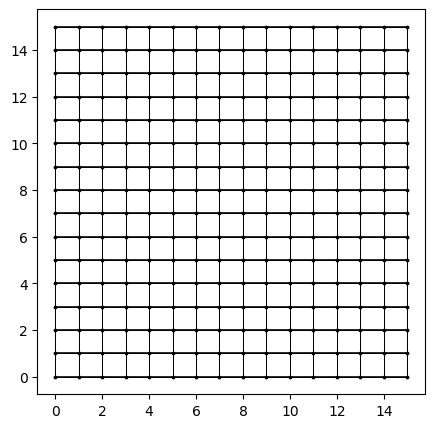

In [47]:
# Generate some parameters
seed = 0
rng = np.random.default_rng(seed)
rands = rng.normal(0, 1, 6)

params = dict(
    N1 = 8,
    N2 = 8,
    mu = rands[0],
    Jx = rands[1],
    Jy = rands[2],
    Jz = rands[3],
    t = 1,
    alpha = rands[4],
    Delta = rands[5],
    pbc = True,
)
params = Params(params)

# Create a system with 8x8 points on the superlattice, and 2x2 sites in the sublattice
four_site = models.Square(N1=2, N2=2)
lattice = models.Square()
lattice.add_sublattice(four_site)
syst = System(Space.RealSpace, lattice, params)

syst.plot()

### Shiba chain - on substrate

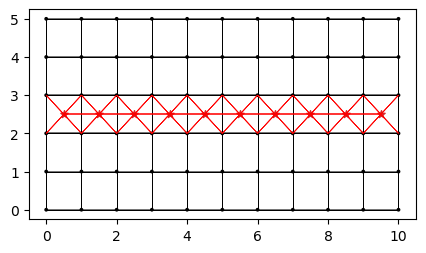

In [10]:
params = dict(
    N1 = 11,
    N2 = 6,
    t = 1,
    mu = -2,
    alpha = 0.5,
    Delta = 1,
    impurities = dict(
        t = 1,
        Gamma = 1,
        mu = 0.5,
        J = 2.5,
        L = 10,
    ),
    pbc = False,
)
params = Params(params)
lattice = models.Square()
sys = System("realspace", lattice, params)
sys.set_geometry("chain")

sys.plot(aspect=6/11, axis_scale=5)

#### Band structure

In [32]:
params = dict(
    t = 1,
    mu = 0,
    alpha = 0.5,
    Delta = 1,
    impurities = dict(
        t = 1,
        Gamma = 1,
        mu = -2,
        J = 1,
        L = 1,
    ),
    direction = "a1",
)
params = Params(params)

lattice = models.Square(spinful=False)
sublattice = models.Square(N1=1, N2=6)
lattice.add_sublattice(sublattice)

kspace = System(Space.KSpace, lattice, params)
kspace.set_geometry("chain")

In [33]:
# Create a path along high symmetry points in momentum space
points = np.array([
    [0, 0],
    [1, 0],
]) * 2 * np.pi
Ks = np.array(k_path(101, points))

Ek = kspace.diagonalise(k=Ks, cache=False)
print(Ek[:, 14].min())

0.12539239379466416


Text(0, 0.5, 'energy E/t')

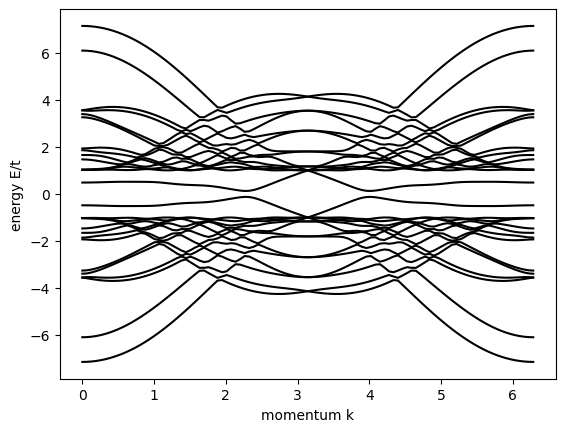

In [34]:
fig, axis = plt.subplots()
axis.plot(Ks[:, 0], Ek, color="black")
axis.set_xlabel("momentum k")
axis.set_ylabel("energy E/t")

#### Topology

In [35]:
@vectorize_parallel
def calc(mu, J):
    params = dict(
        t = 1,
        mu = 0,
        alpha = 0.5,
        Delta = 1,
        impurities = dict(
            t = 1,
            Gamma = 1,
            mu = mu,
            J = J,
            L = 1,
        ),
        direction = "a1",
    )
    params = Params(params)
    
    lattice = models.Square(spinful=False)
    sublattice = models.Square(N1=1, N2=6)
    lattice.add_sublattice(sublattice)
    
    kspace = System(Space.KSpace, lattice, params)
    kspace.set_geometry("chain")
    
    M = kspace.calc_majorana()
    return M

In [30]:
Mus = np.linspace(-4, 4, 31)
Js = np.linspace(-4, 4, 33)

M = calc(Mus[None, :], Js[:, None], progress=True)

  0%|          | 0/1023 [00:00<?, ?it/s]

(<matplotlib.colorbar.Colorbar at 0x7f5b40f551d0>, <Axes: >)

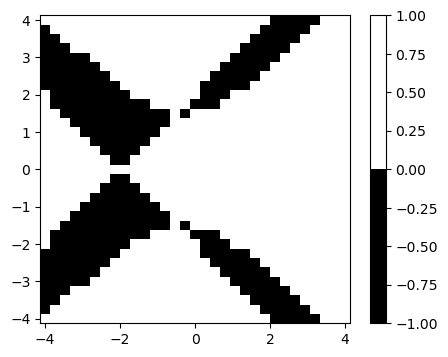

In [31]:
fig, axis = plt.subplots(figsize=(4, 4))
cmap = colours.BlackWhite()
im = axis.pcolormesh(Mus, Js, M, cmap=cmap)
add_colourbar(fig, axis, im)

#### Gap diagrams

In [6]:
@vectorize_parallel
def calc_kspace(mu, J):
    params = dict(
        t = 1,
        mu = 0,
        alpha = 0.5,
        Delta = 1,
        impurities = dict(
            Gamma = 1,
            t = 1,
            mu = mu,
            J = J,
            L = 1,
        ),
        direction = "a1",
    )
    params = Params(params)
    
    lattice = models.Square(spinful=False)
    sublattice = models.Square(N1=1, N2=6)
    lattice.add_sublattice(sublattice)
    
    kspace = System(Space.KSpace, lattice, params)
    kspace.set_geometry("chain")
    
    return kspace.calc_gap(Ks=Ks)

@vectorize_parallel
def calc_realspace(mu, J):
    params = dict(
        N1 = 16,
        N2 = 6,
        t = 1,
        mu = 1,
        alpha = 0.5,
        Delta = 1,
        impurities = dict(
            Gamma = 1,
            t = 1,
            mu = mu.tolist(),
            J = J.tolist(),
            L = 16,
        ),
        pbc = False,
    )
    params = Params(params)

    lattice = models.Square()
    realspace = System(Space.RealSpace, lattice, params)
    realspace.set_geometry("chain")

    E = realspace.diagonalise()
    return E[11]

In [9]:
Mus = np.linspace(-4, 4, 31)
Js = np.linspace(-4, 4, 33)
Ks = np.linspace(0, 2*np.pi, 101)

gaps_kspace = calc_kspace(Mus[None, :], Js[:, None], progress=True)
gaps_realspace = calc_realspace(Mus[None, :], Js[:, None], progress=True)

  0%|          | 0/1023 [00:00<?, ?it/s]

  0%|          | 0/1023 [00:00<?, ?it/s]

Text(0, 0.5, 'exchange strength $J/t$')

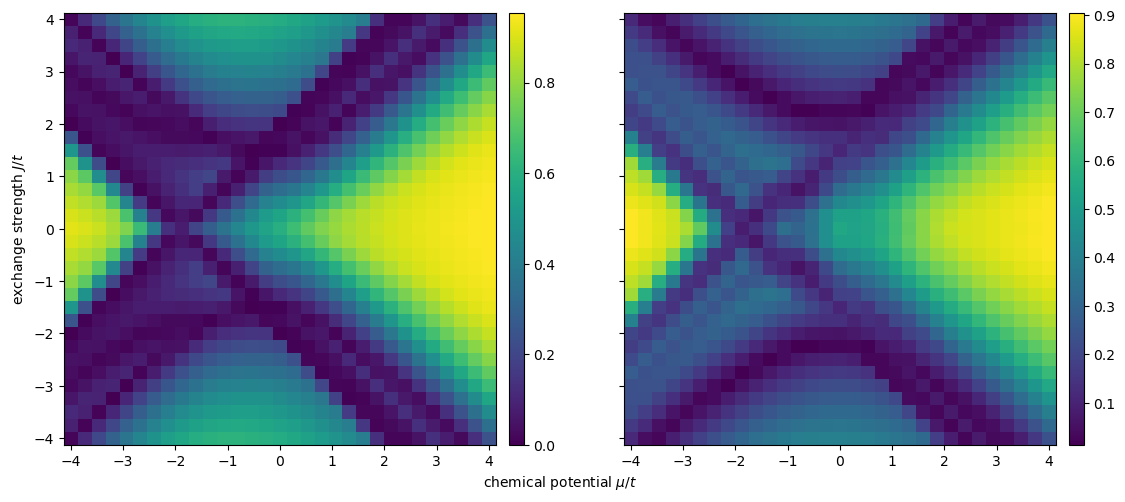

Exception ignored in: <function ResourceTracker.__del__ at 0x7f190ee98180>
Traceback (most recent call last):
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fbce879c180>
Traceback (most recent call last):
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/dcrawford/anaconda3/envs/tightbinding/lib/python3.13/multiprocessing/resource_tracker.py",

In [10]:
fig = plt.figure()
axes = build_axes_grid(fig, 2, 1, aspect=1, xspace=0.2)

im = axes[0].pcolormesh(Mus, Js, gaps_kspace)
add_colourbar(fig, axes[0], im, xscale=0.035, xoff=0.02)
im = axes[1].pcolormesh(Mus, Js, gaps_realspace)
add_colourbar(fig, axes[1], im, xscale=0.035, xoff=0.02)

axes[0].set_xlabel(r"chemical potential $\mu/t$", x=1.15)
axes[0].set_ylabel("exchange strength $J/t$")

#### Realspace

In [36]:
params = dict(
    N1 = 51,
    N2 = 6,
    t = 1,
    mu = 2,
    alpha = 0.5,
    Delta = 1,
    impurities = dict(
        Gamma = 1,
        t = 1,
        mu = -2,
        J = 1,
        L = 11,
    ),
    pbc = False,
)
params = Params(params)

lattice = models.Square()
realspace = System(Space.RealSpace, lattice, params)
realspace.set_geometry("chain")

omega = np.linspace(-2, 2, 1001)
ldos = realspace.calc_ldos(omega, delta=0.01)

Text(0, 0.5, 'DOS [a.u]')

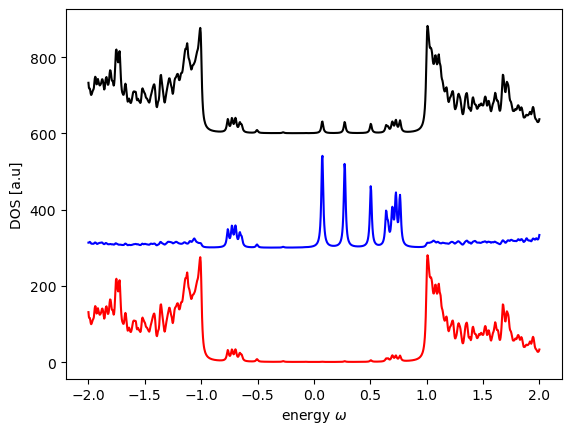

In [43]:
dos = (
    ldos[0][0].sum(axis=(0, 1, 2, 3, 4)),
    ldos[1][0].sum(axis=(0, 1)),
)
dos_tot = np.sum(dos, axis=0)

fig, axis = plt.subplots()

axis.plot(omega, dos[0], color="red")
axis.plot(omega, dos[1]*8+300, color="blue")
axis.plot(omega, dos_tot+600, color="black")
axis.set_xlabel(r"energy $\omega$")
axis.set_ylabel("DOS [a.u]")

In [38]:
@interact(idx=(0, len(omega)-1))
def play(idx=len(omega)//2):
    _ldos = ldos[0][0, :, :, 0, 0, :, idx].sum(axis=-1)

    fig, axis = plt.subplots(figsize=(5, 5))
    axis.plot(_ldos, ".-")

    axis.set_xlabel("x")
    axis.set_ylabel("y")

interactive(children=(IntSlider(value=500, description='idx', max=1000), Output()), _dom_classes=('widget-inte…

In [39]:
@interact(idx=(0, len(omega)-1))
def play(idx=len(omega)//2):
    _ldos = ldos[1][0, :, :, idx].sum(axis=1)

    fig, axis = plt.subplots(figsize=(5, 5))
    axis.plot(_ldos, ".-", color="black")

    axis.set_xlabel("x")
    axis.set_ylabel("y")

interactive(children=(IntSlider(value=500, description='idx', max=1000), Output()), _dom_classes=('widget-inte…